## Anomaly detection

https://hackmd.io/@shaoeChen/SJkSrunVL#%E6%9D%8E%E5%AE%8F%E6%AF%85_Anomaly-Detection


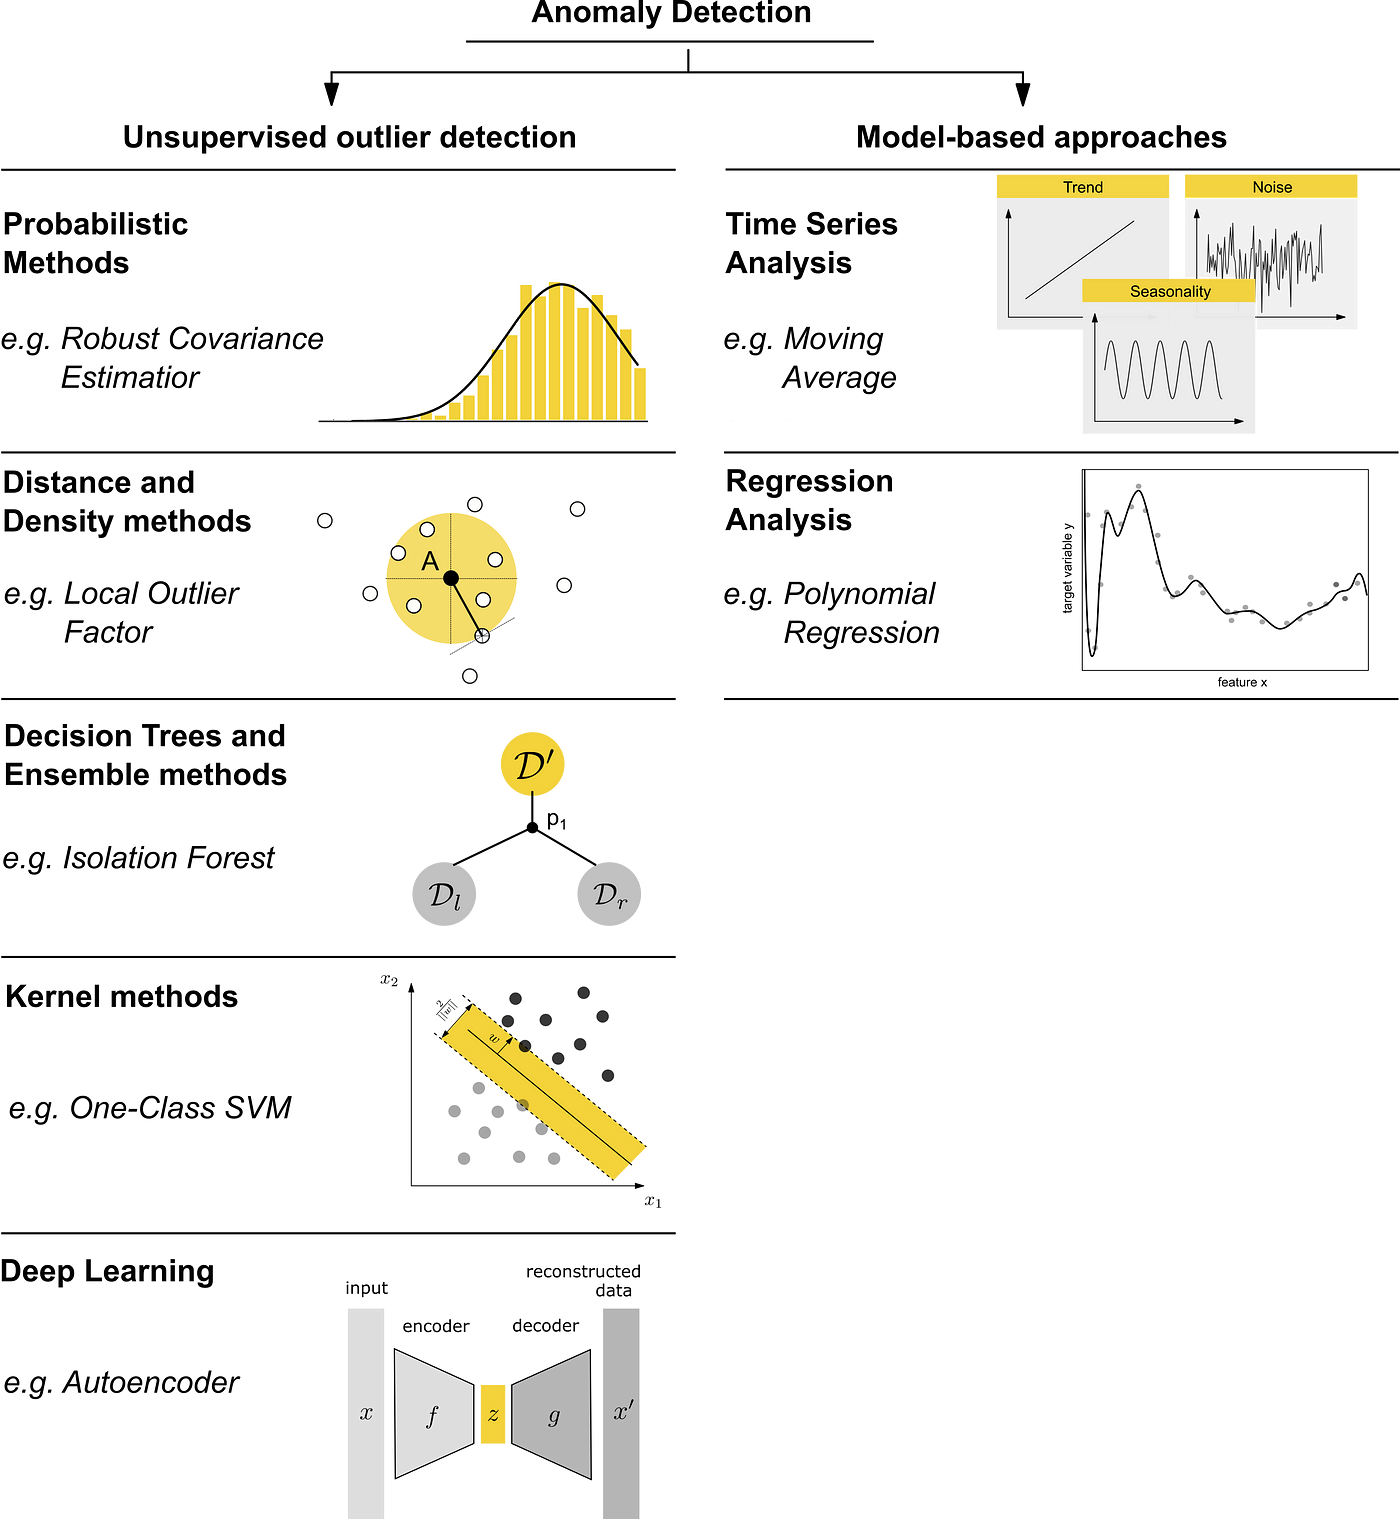

## 傳統機器學習方法

- 統計方法
Z-Score: 使用標準差來衡量數據點與均值的距離。<br>
IQR (Interquartile Range): 利用數據的四分位距離來檢測異常值。<br>

- 密度方法
K-Nearest Neighbors (KNN): 計算每個點與其最近的K個鄰居的距離，距離過大的點可能是異常值。<br>
Local Outlier Factor (LOF): 基於密度的異常檢測方法，通過比較每個點的密度與其鄰居的密度來判斷異常。<br>

- 聚類方法
K-Means: 聚類後，與聚類中心距離過大的點可能是異常。<br>
DBSCAN (Density-Based Spatial Clustering of Applications with Noise): 可以自動識別異常點（即噪聲）。<br>


## 深度學習方法

- 自編碼器（Autoencoder）
Autoencoder: 將數據壓縮並重建，重建誤差大的數據點可能是異常。<br>
Variational Autoencoder (VAE): 基於概率的自編碼器，用於生成和檢測異常。<br>

- 生成對抗網絡（GANs）
Generative Adversarial Networks (GANs): 通過生成模型和判別模型的對抗訓練，生成異常點的樣本並檢測異常。<br>

- 遞歸神經網絡（RNN）
LSTM (Long Short-Term Memory): 用於處理時間序列數據，通過預測未來數據點並比較實際數據與預測數據的差異來檢測異常。<br>
GRU (Gated Recurrent Unit): 與LSTM類似，用於時間序列異常檢測。<br>

- 圖神經網絡（GNN）
Graph Convolutional Networks (GCNs): 用於處理圖結構數據中的異常檢測，例如社交網絡中的異常行為檢測。<br>

--- 
# 綜合方法
## 集成學習（Ensemble Learning）

Isolation Forest: 將數據集隨機分割成樹結構，異常點通常在樹的較淺層處分離。<br>
Random Cut Forest: 擴展了Isolation Forest的概念，用於大規模異常檢測。<br>

## Hybrid Methods
結合上述多種方法，例如將自編碼器和KNN結合，先用自編碼器降維，再用KNN檢測異常。



## Isolation Forest

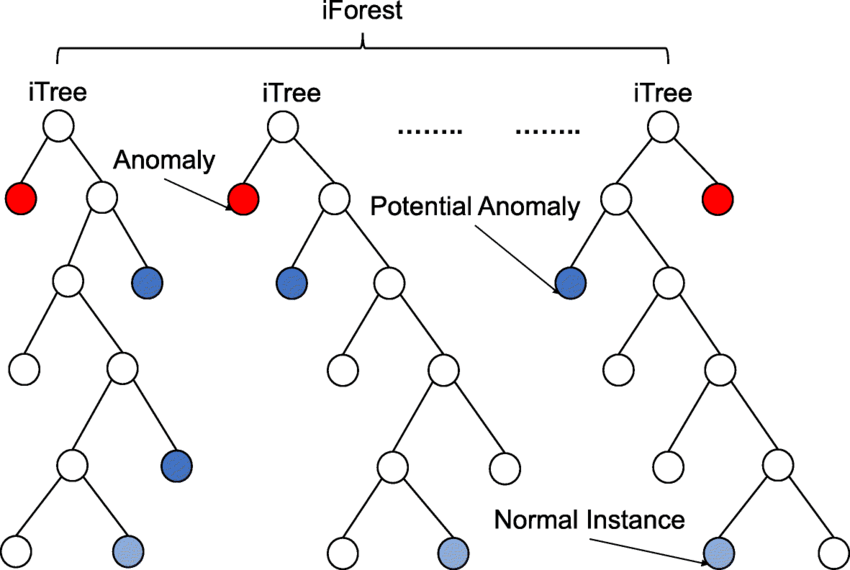

In [105]:
import os 
import numpy as np
import random
from random import sample
from numpy import random
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

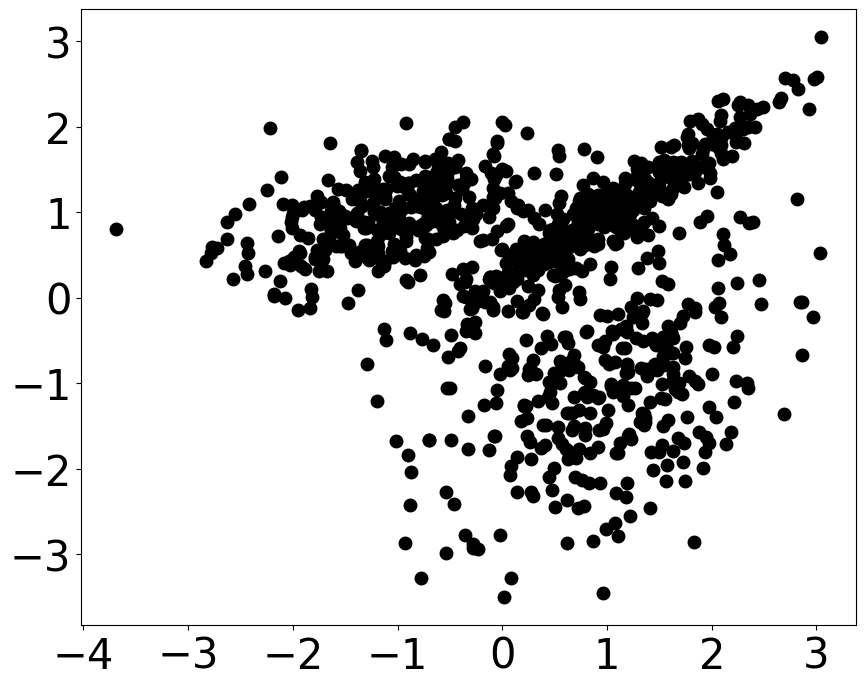

In [106]:
X, _ = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=3,  # Reduced to 4 classes to satisfy the condition
    random_state=150
)

# Plot the dataset
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(X[:, 0], X[:, 1], "ko", markersize=9)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

## Isolation Tree

In [107]:
import numpy as np
import random

def Isolation_Tree(X, X_real, index, depth, lim, depth_array):
    """
    Isolation Tree 遞迴構建函數，用於計算每個數據點的深度，以進行異常檢測。

    參數：
    X - numpy 數組，當前節點的數據子集。
    X_real - numpy 數組，完整的數據集。
    index - 當前節點數據子集的索引。
    depth - 當前節點的深度。
    lim - 最大遞迴深度。
    depth_array - numpy 數組，用於存儲每個數據點的深度。

    返回：
    depth_array - 更新後的深度數組。
    """
    # 當前深度達到限制時，返回深度數組
    if(depth == lim):
        return depth_array
    
    # 獲取數據集的特徵數量
    M = X.shape[1]
    
    # 隨機選擇一個特徵進行分割
    q = random.randint(0, M-1)
    
    # 在選定特徵的取值範圍內隨機選擇一個分割點
    p = random.uniform(np.min(X[:, q]), np.max(X[:, q]))
    
    # 根據分割點將數據分為兩部分
    BOOL = (X[:, q] < p)
    left_index, right_index = index[BOOL], index[~BOOL]
    
    # 打印當前深度及分割後的索引（調試用）
    # print(depth, left_index, right_index)
    
    # 若左子集僅有一個數據點且右子集也僅有一個數據點，則更新深度數組
    if(len(left_index) == 1 and len(right_index) == 1):
        depth_array[left_index] = depth
        depth_array[right_index] = depth
        return depth_array
    
    # 若左子集僅有一個數據點，則更新其深度並遞迴處理右子集
    elif(len(left_index) == 1):
        depth_array[left_index] = depth
        depth_array = Isolation_Tree(X[~BOOL], X_real, right_index, depth+1, lim, depth_array)
        return depth_array
    
    # 若右子集僅有一個數據點，則更新其深度並遞迴處理左子集
    elif(len(right_index) == 1):
        depth_array[right_index] = depth
        depth_array = Isolation_Tree(X[BOOL], X_real, left_index, depth+1, lim, depth_array)
        return depth_array
    
    # 若兩子集均有多個數據點，則分別遞迴處理左右子集
    else:
        depth_array = Isolation_Tree(X[BOOL], X_real, left_index, depth+1, lim, depth_array)
        depth_array = Isolation_Tree(X[~BOOL], X_real, right_index, depth+1, lim, depth_array)
        return depth_array


## Isolation Forest

In [108]:
N=X.shape[0]
sample_size=900
max_iter=30
threshold=4
lim=50
depth_array=np.ones((max_iter,N))*lim
for i in range(max_iter):
    real_index=np.array(sample(range(0,N), k=sample_size))
    depth_array[i]=Isolation_Tree(X[real_index],X,real_index,0,lim,depth_array[i])
outlier=np.array(np.where(np.sum(depth_array<threshold,axis=0)!=0)).flatten()
print(outlier)

[ 26  37  47  63 108 109 147 150 201 228 238 256 263 271 320 362 384 411
 422 467 487 494 531 532 537 572 604 716 718 746 789 812 860 862 875 884
 954 970]


## Plot

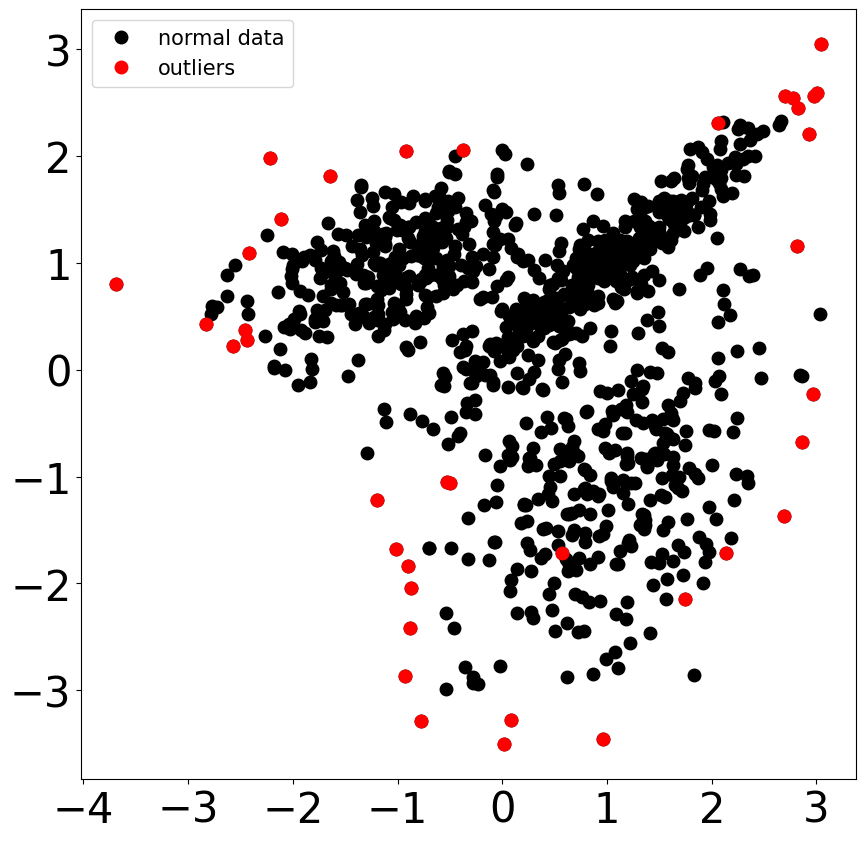

In [110]:

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(X[:,0],X[:,1],"ko",markersize=9,label="normal data")
plt.plot(X[outlier,0],X[outlier,1],"ro",markersize=9,label="outliers")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=15)
plt.show()